# Цели ```03_exploratory_analysis.ipynb```

В этом ноутбуке проводится предварительный разведочный анализ (EDA) для понимания структуры и закономерностей в данных.

**Основные цели:**
- Изучить распределения просмотров и ключевых признаков (теги, длина заголовка, сущности).
- Выявить выбросы, перекосы и дисбаланс в данных.
- Посчитать частотность слов, тегов и сущностей, определить, какие темы и слова наиболее популярны.
- Сравнить популярные и непопулярные статьи по содержанию.
- Подготовить основу для глубокой аналитики и построения модели.


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
from wordcloud import WordCloud
import ast

In [87]:
# Загрузка обработанных данных
data_path = Path.cwd().parent / "data" / "processed" / "clean_articles.csv"
df = pd.read_csv(data_path)

# Выводим сводную таблицу с количеством строк, типами и непустыми значениями
summary = pd.DataFrame({
    'Тип данных': df.dtypes,
    'Количество значений': df.count(),
    'Пропусков': df.isna().sum()
})
print("📋 Обзор структуры таблицы:")
display(summary)

# Покажем первые строки таблицы с ограничением по ширине столбцов
with pd.option_context('display.max_colwidth', 80):
    display(df.head(5))

📋 Обзор структуры таблицы:


,Тип данных,Количество значений,Пропусков
category,object,1188,0
url,object,1188,0
title,object,1188,0
views,int64,1188,0
tags,object,1188,0
title_clean,object,1188,0
title_tokens,object,1188,0
title_lemmas,object,1188,0
named_entities,object,1188,0


,category,url,title,views,tags,title_clean,title_tokens,title_lemmas,named_entities
0,Политика,https://rsport.ria.ru/20250429/stupak-2014106405.html,вяльбе поддержала участие ступак в партийных выборах,25,"['Политика', 'Лыжные гонки', 'Республика Коми', 'Сосногорск (район)']",вяльбе поддержала участие ступак партийных выборах,"['вяльбе', 'поддержала', 'участие', 'ступак', 'партийных', 'выборах']","['вяльбе', 'поддержать', 'участие', 'ступак', 'партийный', 'выбор']","[('вяльбе', 'PER')]"
1,Политика,https://ria.ru/20250429/putin-2014072360.html,путин прилетел в волгоград,1825,"['Политика', 'Волгоград', 'Россия', 'Владимир Путин', 'Александр Лукашенко']",путин прилетел волгоград,"['путин', 'прилетел', 'волгоград']","['путин', 'прилететь', 'волгоград']","[('путин', 'PER'), ('волгоград', 'LOC')]"
2,Политика,https://ria.ru/20250429/volodin-2014019151.html,володин назвал защиту исторической правды одним из приоритетов сг,263,"['Политика', 'Белоруссия', 'Волгоград', 'Владимир Путин']",володин назвал защиту исторической правды одним приоритетов сг,"['володин', 'назвал', 'защиту', 'исторической', 'правды', 'одним', 'приорите...","['володин', 'назвать', 'защита', 'исторический', 'правда', 'одним', 'приорит...","[('володин', 'PER'), ('сг', 'ORG')]"
3,Политика,https://ria.ru/20250429/peskov-2014002713.html,песков высказался о легитимности зеленского на посту президента,9770,"['Политика', 'Россия', 'Дмитрий Песков', 'Владимир Зеленский', 'Украина']",песков высказался легитимности зеленского посту президента,"['песков', 'высказался', 'легитимности', 'зеленского', 'посту', 'президента']","['песков', 'высказаться', 'легитимность', 'зеленского', 'пост', 'президент']","[('песков', 'PER')]"
4,Политика,https://ria.ru/20250429/klishas-2013972100.html,сенатор клишас шуткой отреагировал на слова володина о нем,11183,"['Политика', 'Госдума РФ', 'Андрей Клишас', 'Вячеслав Володин']",сенатор клишас шуткой отреагировал слова володина нем,"['сенатор', 'клишас', 'шуткой', 'отреагировал', 'слова', 'володина', 'нем']","['сенатор', 'клишас', 'шутка', 'отреагировать', 'слово', 'володин', 'нем']","[('клишас шуткой', 'PER')]"


In [23]:
# Преобразуем строковые представления списков тегов обратно в списки
if df["tags"].apply(type).eq(str).any():
    df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

print(f"Загружено записей: {len(df)}")
df.head()

Загружено записей: 1188


,category,url,title,views,tags,title_clean,title_tokens,title_lemmas,named_entities
0,Политика,https://rsport.ria.ru/20250429/stupak-20141064...,вяльбе поддержала участие ступак в партийных в...,25,"[Политика, Лыжные гонки, Республика Коми, Сосн...",вяльбе поддержала участие ступак партийных выб...,"['вяльбе', 'поддержала', 'участие', 'ступак', ...","['вяльбе', 'поддержать', 'участие', 'ступак', ...","[('вяльбе', 'PER')]"
1,Политика,https://ria.ru/20250429/putin-2014072360.html,путин прилетел в волгоград,1825,"[Политика, Волгоград, Россия, Владимир Путин, ...",путин прилетел волгоград,"['путин', 'прилетел', 'волгоград']","['путин', 'прилететь', 'волгоград']","[('путин', 'PER'), ('волгоград', 'LOC')]"
2,Политика,https://ria.ru/20250429/volodin-2014019151.html,володин назвал защиту исторической правды одни...,263,"[Политика, Белоруссия, Волгоград, Владимир Путин]",володин назвал защиту исторической правды одни...,"['володин', 'назвал', 'защиту', 'исторической'...","['володин', 'назвать', 'защита', 'исторический...","[('володин', 'PER'), ('сг', 'ORG')]"
3,Политика,https://ria.ru/20250429/peskov-2014002713.html,песков высказался о легитимности зеленского на...,9770,"[Политика, Россия, Дмитрий Песков, Владимир Зе...",песков высказался легитимности зеленского пост...,"['песков', 'высказался', 'легитимности', 'зеле...","['песков', 'высказаться', 'легитимность', 'зел...","[('песков', 'PER')]"
4,Политика,https://ria.ru/20250429/klishas-2013972100.html,сенатор клишас шуткой отреагировал на слова во...,11183,"[Политика, Госдума РФ, Андрей Клишас, Вячеслав...",сенатор клишас шуткой отреагировал слова волод...,"['сенатор', 'клишас', 'шуткой', 'отреагировал'...","['сенатор', 'клишас', 'шутка', 'отреагировать'...","[('клишас шуткой', 'PER')]"


## 1. Распределение просмотров (логарифмическая шкала)
Этот график показывает, как распределяются просмотры среди всех статей.

Так как распределение просмотров сильно смещено — много статей с малыми значениями и несколько с очень большими
(миллионы), мы используем логарифмическую шкалу по оси X, чтобы визуализировать данные более равномерно и увидеть "тело" распределения.

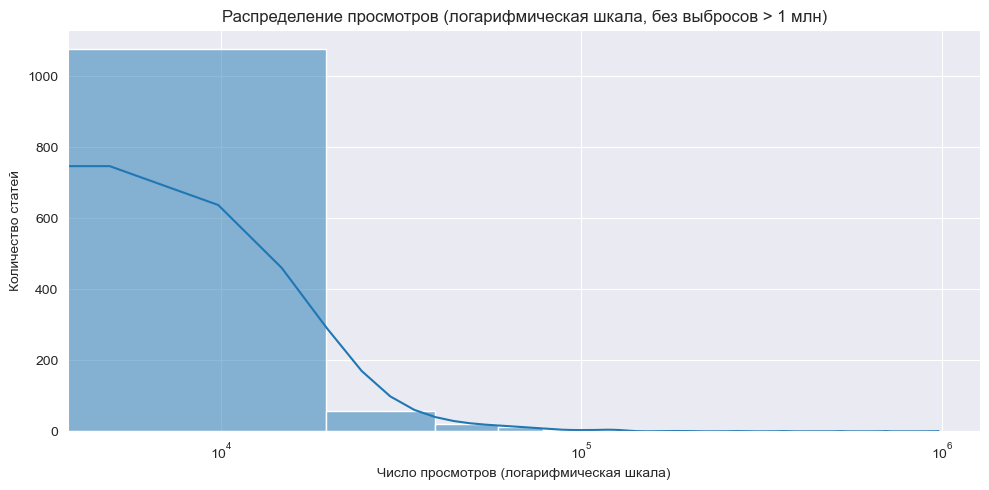

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df[df["views"] < 1_000_000]["views"], bins=50, kde=True)
plt.xscale("log")
plt.title("Распределение просмотров (логарифмическая шкала, без выбросов > 1 млн)")
plt.xlabel("Число просмотров (логарифмическая шкала)")
plt.ylabel("Количество статей")
plt.tight_layout()
plt.show()

## 2. Boxplot просмотров по категориям
Этот график позволяет сравнить распределение просмотров по категориям.

Он показывает медиану, квартильные границы и выбросы.

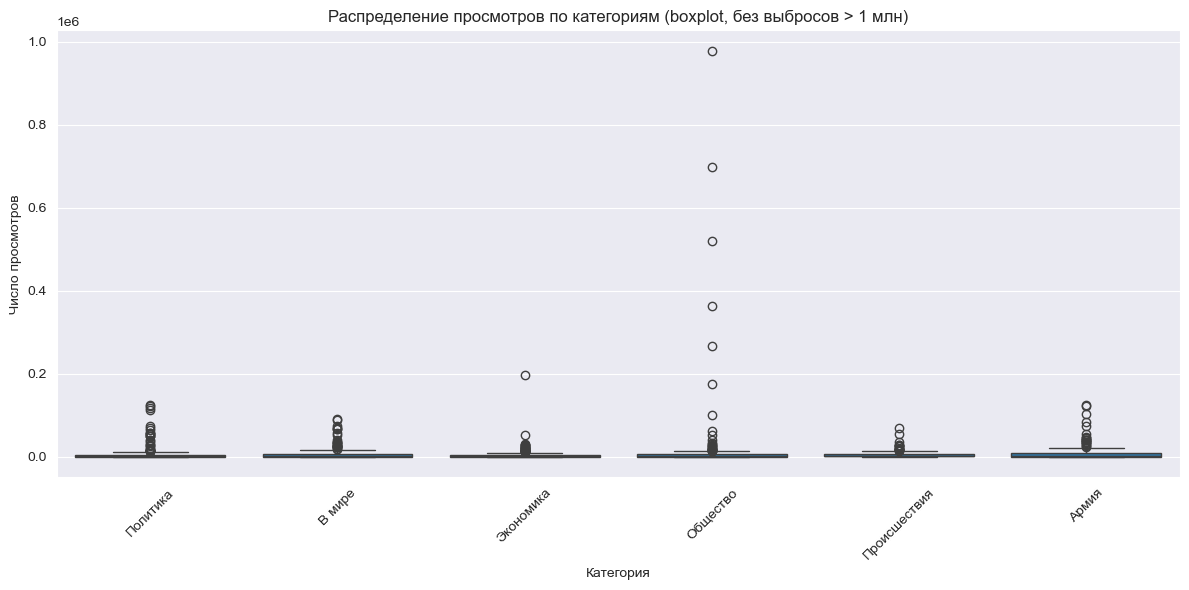

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="category", y="views", data=df[df["views"] < 1_000_000])
plt.xticks(rotation=45)
plt.title("Распределение просмотров по категориям (boxplot, без выбросов > 1 млн)")
plt.xlabel("Категория")
plt.ylabel("Число просмотров")
plt.tight_layout()
plt.show()

## 3. Топ-10 статей по просмотрам
Таблица с самыми просматриваемыми статьями, полезна для изучения их общих черт.

In [11]:
top10 = df.sort_values(by="views", ascending=False).head(10)
print("Топ-10 самых просматриваемых статей:")
top10[["category", "title", "views"]]

Топ-10 самых просматриваемых статей:


,category,title,views
655,Общество,что такое ретроградный меркурий и как он влияе...,7817121
611,Общество,как отдыхаем в мае 2025 года: праздники и пере...,5501491
254,В мире,родительские субботы в 2025 году: расписание и...,3058172
657,Общество,банкротство физических лиц в 2025 году: порядо...,1151357
656,Общество,как встать на биржу труда в 2025 году: пошагов...,978061
605,Общество,расписание егэ в 2025-м: даты проведения экзам...,698899
695,Общество,"магнитные бури сегодня: причины, влияние на зд...",518856
735,Общество,как отдыхаем в июне 2025: производственный кал...,364415
600,Общество,"радоница в 2025 году: когда будет, история пра...",268273
485,Экономика,"ключевая ставка цб рф: для чего нужна, почему ...",196200


## 4. Частотность слов (лемм) в заголовках
Подсчитаем, какие леммы чаще всего встречаются в заголовках всех новостей.

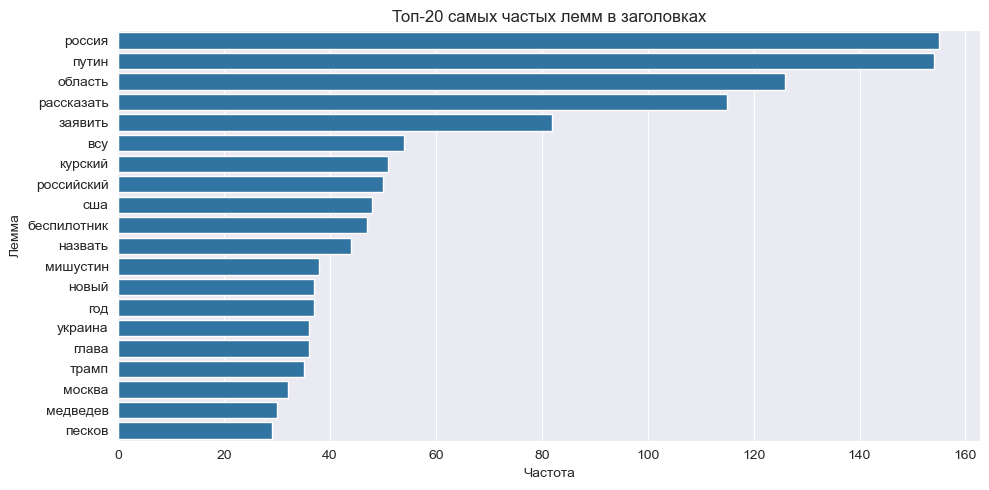

In [16]:
all_lemmas = df["title_lemmas"].dropna().apply(eval).sum()
lemma_freq = Counter(all_lemmas)
top_lemmas = pd.DataFrame(lemma_freq.most_common(20), columns=["Лемма", "Частота"])

plt.figure(figsize=(10, 5))
sns.barplot(data=top_lemmas, x="Частота", y="Лемма")
plt.title("Топ-20 самых частых лемм в заголовках")
plt.xlabel("Частота")
plt.ylabel("Лемма")
plt.tight_layout()
plt.show()

## 5. Частотность тегов и их связь с просмотрами
Посчитаем самые популярные теги и усреднённое число просмотров для каждого из них.

In [25]:
tags_expanded = df.explode("tags")
tag_stats = tags_expanded.groupby("tags")["views"].agg(["count", "mean"]).sort_values("count", ascending=False)

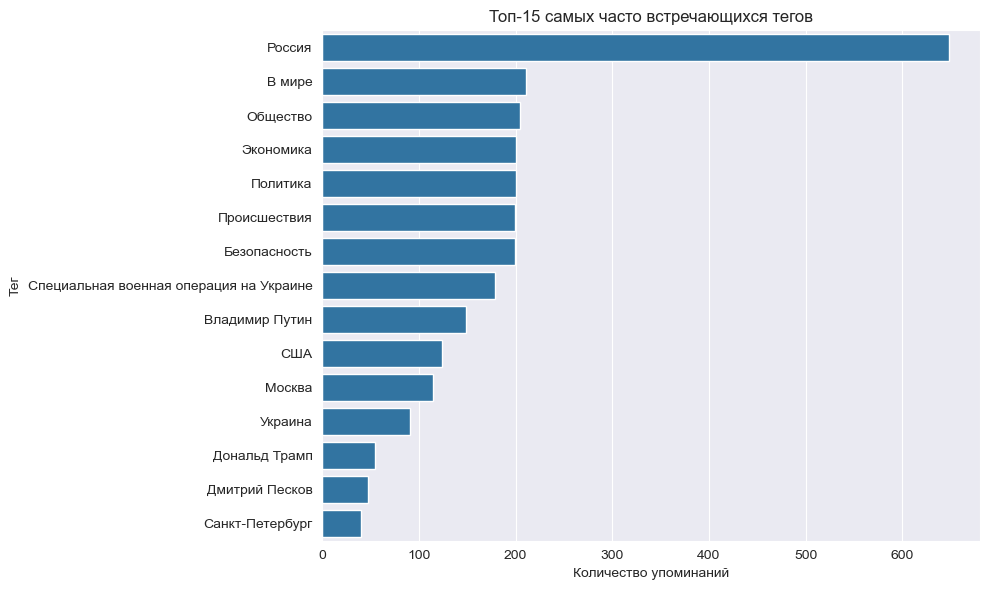

In [26]:
# Выведем топ-15 самых часто встречающихся тегов
top_tags = tag_stats.head(15).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_tags, x="count", y="tags")
plt.title("Топ-15 самых часто встречающихся тегов")
plt.xlabel("Количество упоминаний")
plt.ylabel("Тег")
plt.tight_layout()
plt.show()

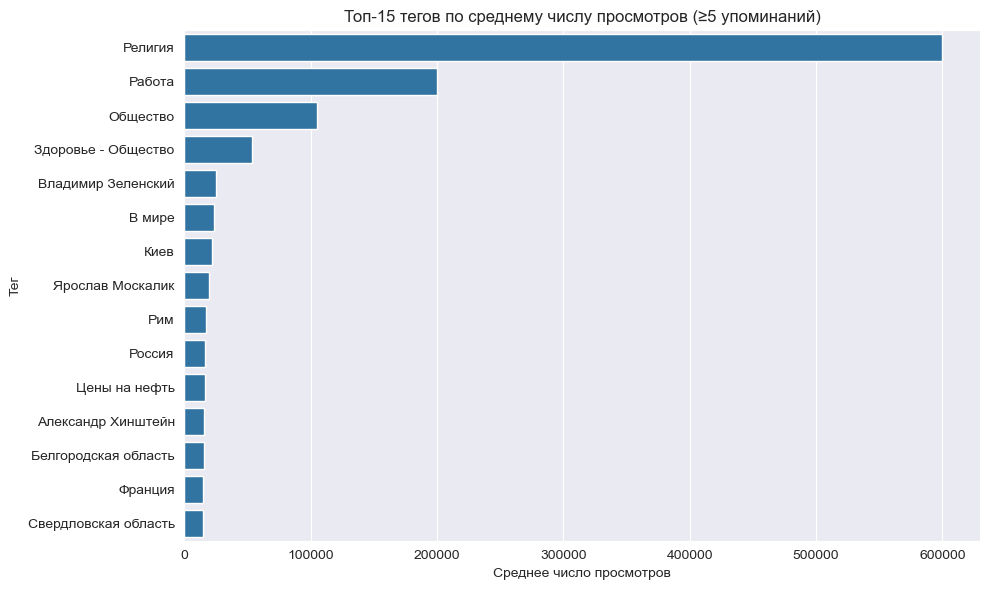

In [27]:
# И топ-15 тегов с наибольшими средними просмотрами (если упоминались хотя бы 5 раз)
popular_tags = tag_stats[tag_stats["count"] >= 5].sort_values("mean", ascending=False).head(15).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=popular_tags, x="mean", y="tags")
plt.title("Топ-15 тегов по среднему числу просмотров (≥5 упоминаний)")
plt.xlabel("Среднее число просмотров")
plt.ylabel("Тег")
plt.tight_layout()
plt.show()


## 6. Частотность упоминаний именованных сущностей (NER)
Подсчитаем, какие именованные сущности чаще всего встречаются в заголовках.

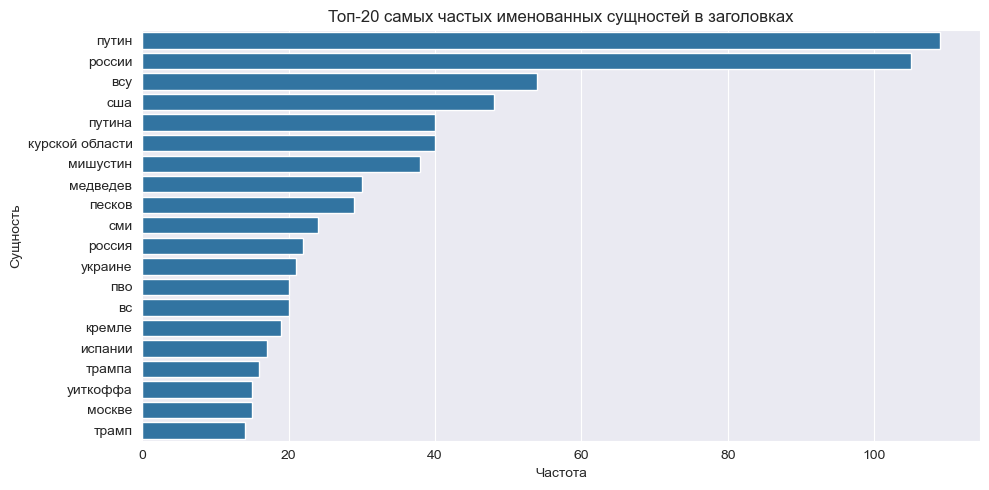

In [28]:
if "named_entities" in df.columns:
    all_ents = df["named_entities"].dropna().apply(eval).sum()
    ent_texts = [ent[0] for ent in all_ents]
    ent_freq = Counter(ent_texts)
    top_ents = pd.DataFrame(ent_freq.most_common(20), columns=["Сущность", "Частота"])

    plt.figure(figsize=(10, 5))
    sns.barplot(data=top_ents, x="Частота", y="Сущность")
    plt.title("Топ-20 самых частых именованных сущностей в заголовках")
    plt.xlabel("Частота")
    plt.ylabel("Сущность")
    plt.tight_layout()
    plt.show()


## 7. Сравнение популярных и непопулярных статей по леммам
Этот блок показывает, какие слова (леммы) чаще встречаются в популярных статьях.

In [41]:
# Разделим статьи на 2 группы: верхние 10% по просмотрам и нижние 90%
thresh = df["views"].quantile(0.85)
df["popularity"] = df["views"].apply(lambda x: "Топ 10%" if x >= thresh else "Остальные")

In [45]:
# Подсчитаем частоты лемм в каждой группе
def get_lemma_freq(subset):
    return Counter(subset["title_lemmas"].dropna().apply(eval).sum())

freq_top = get_lemma_freq(df[df["popularity"] == "Топ 10%"])
freq_rest = get_lemma_freq(df[df["popularity"] == "Остальные"])

In [46]:
# Вычислим относительную разницу: (freq_top - freq_rest) / (freq_top + freq_rest)
lemmas_common = set(freq_top) & set(freq_rest)
lemma_diff = [
    (lemma, freq_top[lemma], freq_rest[lemma], (freq_top[lemma] - freq_rest[lemma]) / (freq_top[lemma] + freq_rest[lemma]))
    for lemma in lemmas_common if freq_top[lemma] + freq_rest[lemma] > 5
]

lemma_diff_df = pd.DataFrame(lemma_diff, columns=["Лемма", "В топ-10%", "В остальных", "Относительная разница"])
lemma_diff_df = lemma_diff_df.sort_values("Относительная разница", ascending=False).head(20)

Положительное значение означает, что лемма чаще встречается в топ-10% статей по просмотрам.
Отрицательное — что лемма более характерна для непопулярных статей.

Мы используем относительную разницу:

```Разница = (упоминания в топ-10% − в остальных 90%) / (сумма упоминаний в обеих группах)```

Это позволяет устранить перекос, вызванный тем, что непопулярных статей значительно больше.

Относительная метрика помогает корректно сравнивать, насколько лемма "предпочтительнее" в популярных статьях, а не просто чаще по абсолютным числам.

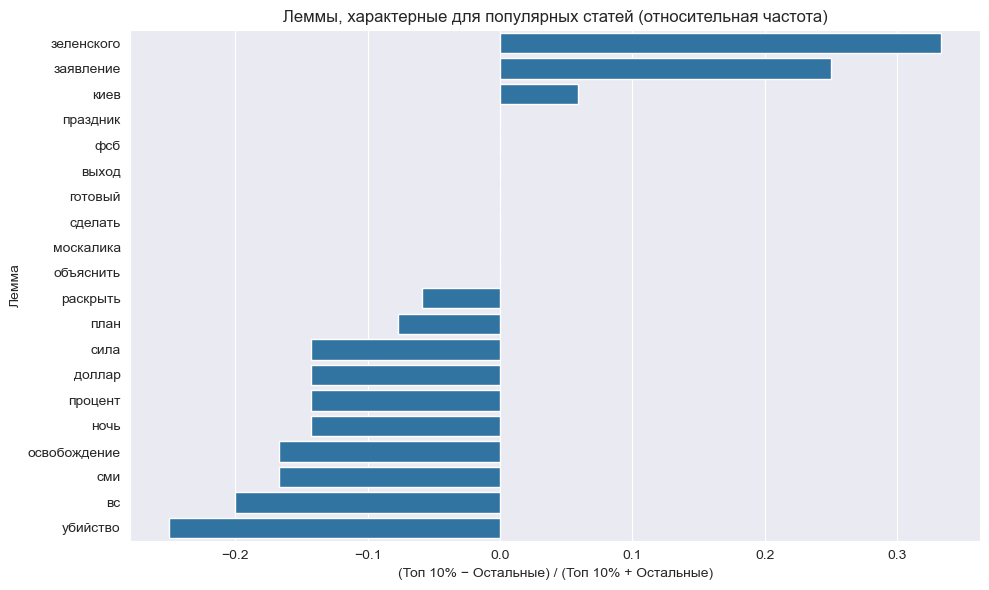

In [47]:
# График слов, характерных для популярных статей
plt.figure(figsize=(10, 6))
sns.barplot(data=lemma_diff_df, x="Относительная разница", y="Лемма")
plt.title("Леммы, характерные для популярных статей (относительная частота)")
plt.xlabel("(Топ 10% − Остальные) / (Топ 10% + Остальные)")
plt.ylabel("Лемма")
plt.tight_layout()
plt.show()


## 8. Корреляции признаков с числом просмотров
Этот блок исследует возможные взаимосвязи между характеристиками статьи и её популярностью.
Мы анализируем числовые признаки: количество тегов, слов в заголовке и именованных сущностей.

Первый график — тепловая карта корреляций (heatmap), показывает степень линейной зависимости между переменными.
Коэффициент варьируется от -1 (обратная связь) до 1 (прямая), 0 — отсутствие зависимости.

Второй — диаграммы рассеяния (scatter plot). Они визуализируют связь между парой переменных, где каждая точка — это статья.
Если точки идут по диагонали, есть линейная зависимость. Если облако разрознено — зависимости нет.

In [49]:
# Число тегов, слов в заголовке и сущностей
if df["tags"].apply(type).eq(str).any():
    df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

if "title_tokens" in df.columns and df["title_tokens"].apply(type).eq(str).any():
    df["title_tokens"] = df["title_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

if "named_entities" in df.columns and df["named_entities"].apply(type).eq(str).any():
    df["named_entities"] = df["named_entities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [55]:
# Добавим числовые признаки
df["num_tags"] = df["tags"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df["num_words"] = df["title_tokens"].apply(lambda x: len(x) if isinstance(x, list) else 0)
df["num_entities"] = df["named_entities"].apply(lambda x: len(x) if isinstance(x, list) else 0)

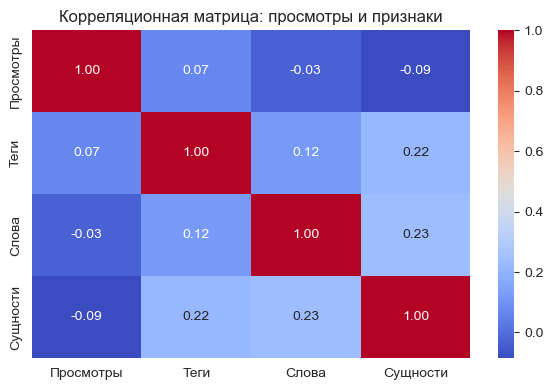

In [56]:
# Вычислим корреляции
corr_df = df[["views", "num_tags", "num_words", "num_entities"]].corr()
corr_df.index = ["Просмотры", "Теги", "Слова", "Сущности"]
corr_df.columns = ["Просмотры", "Теги", "Слова", "Сущности"]

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица: просмотры и признаки")
plt.tight_layout()
plt.show()

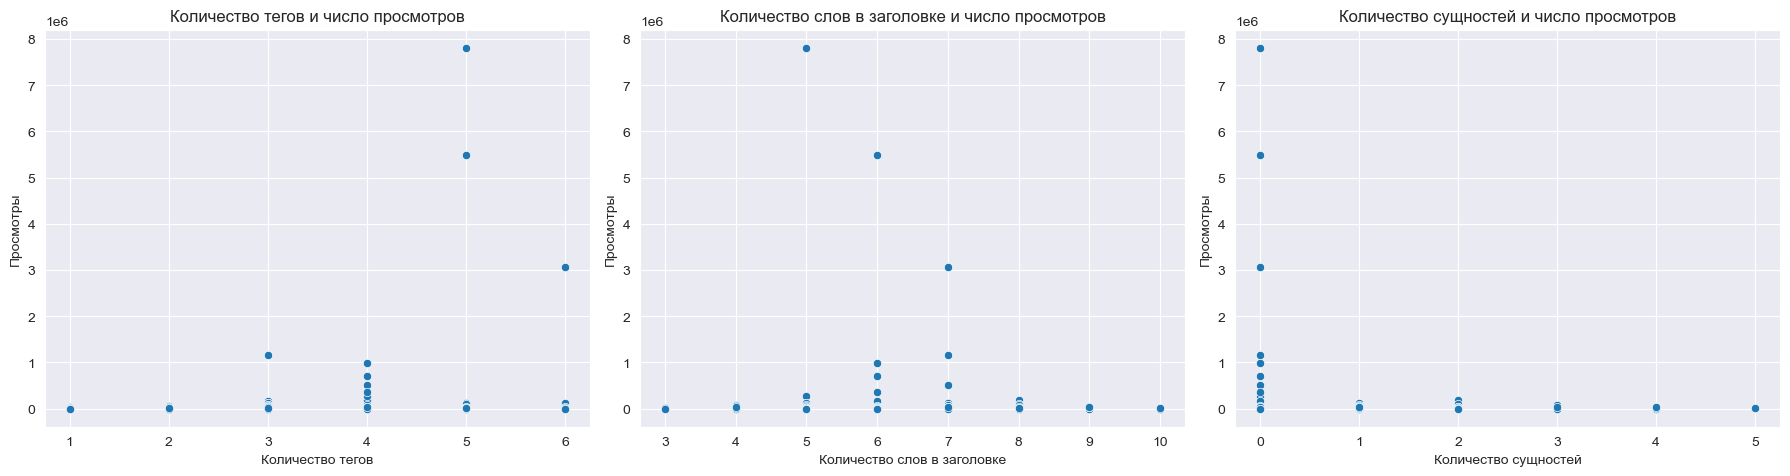

In [57]:
# Дополнительно: диаграммы рассеяния
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(data=df, x="num_tags", y="views", ax=axs[0])
axs[0].set_title("Количество тегов и число просмотров")
axs[0].set_xlabel("Количество тегов")
axs[0].set_ylabel("Просмотры")
sns.scatterplot(data=df, x="num_words", y="views", ax=axs[1])
axs[1].set_title("Количество слов в заголовке и число просмотров")
axs[1].set_xlabel("Количество слов в заголовке")
axs[1].set_ylabel("Просмотры")
sns.scatterplot(data=df, x="num_entities", y="views", ax=axs[2])
axs[2].set_title("Количество сущностей и число просмотров")
axs[2].set_xlabel("Количество сущностей")
axs[2].set_ylabel("Просмотры")
plt.tight_layout()
plt.show()


## 9. WordCloud — облака слов по леммам

In [73]:
# Фильтрация
popular = df.sort_values("views", ascending=False).head(200)
unpopular = df[df["views"] > 0].sort_values("views").head(200)

In [74]:
# Леммы
lemmas_popular = Counter(sum(popular["title_lemmas"].dropna().apply(eval).tolist(), []))
lemmas_unpopular = Counter(sum(unpopular["title_lemmas"].dropna().apply(eval).tolist(), []))

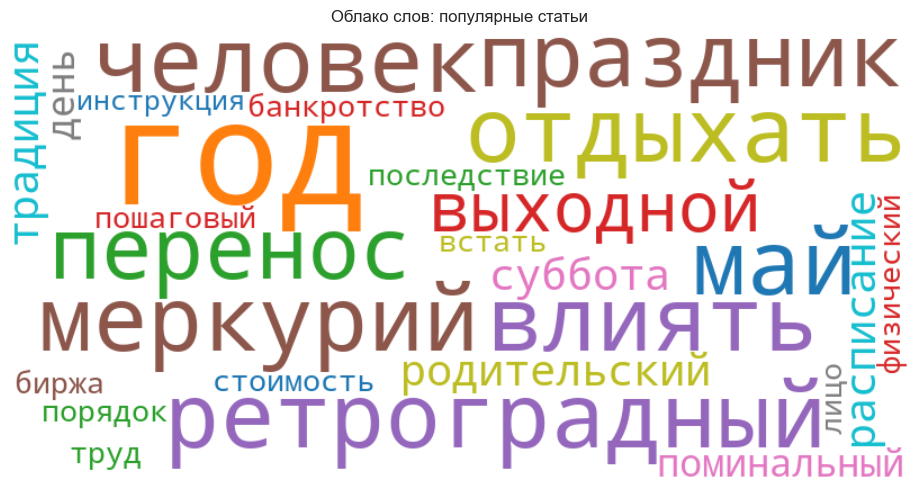

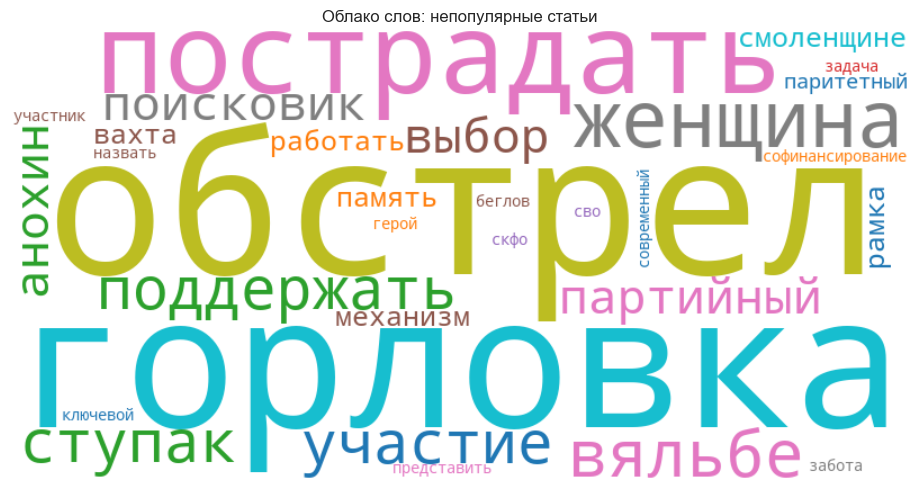

In [75]:
# Визуализация
def show_wordcloud(counter, title):
    wc = WordCloud(width=800, height=400, background_color='white', colormap='tab10')
    wc.generate_from_frequencies(counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

show_wordcloud(lemmas_popular, "Облако слов: популярные статьи")
show_wordcloud(lemmas_unpopular, "Облако слов: непопулярные статьи")